In [1]:
from keras import Model
from keras.initializers import RandomNormal, Zeros
from keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, \
    Activation, Dropout, Add, Conv2DTranspose, \
    LeakyReLU, Concatenate

from keras.optimizers import Adam

import os
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
from PIL import Image
import numpy as np

2024-01-25 17:30:33.434643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 17:30:33.434738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 17:30:33.438265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 17:30:33.476538: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 17:30:34.325188: W tensorflow/compiler/tf2

In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import random
import keras
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from IPython.display import clear_output
from IPython.display import Image

seed = 2019
np.random.seed = seed
random.seed = seed
tf.random.set_seed(seed)
path = os.getcwd()

In [3]:
image_id_list = os.listdir("./dataset/original")

In [4]:
image_size = (256, 256)
train_path = "./dataset/"
epochs = 30
validation_size = 16

In [25]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ids, filepath, batch_size=16, image_size=(256, 256), channels=3):
        self.ids=ids
        self.filepath=filepath
        self.batch_size=batch_size
        self.image_size=image_size
        self.channels=channels
        
    def __len__(self):
            return (len(self.ids)//self.batch_size)
            
    def __getitem__(self,index):
            indexes = range(
                index*self.batch_size,
                index*self.batch_size+self.batch_size
            )
            
            ids_to_load = [self.ids[k] for k in indexes]
            X = self.__generate_x(ids_to_load)
            y = self.__generate_y(ids_to_load)
            l = []
            for i, m in enumerate(X):
                l.append(m.reshape(256, 256, 3))
            X = np.array(l)
            l = []
            for i, m in enumerate(y):
                l.append(m.reshape(256, 256, 3))
            y = np.array(l)
            return X, y
            
    def __generate_x(self,id_names):
            X = np.zeros((self.batch_size, self.image_size[0], self.image_size[1], self.channels))
            for i,id_n in enumerate(id_names):
                img = cv2.imread(self.filepath + '/sketch/' + id_n)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.astype(np.float32)/255.
                img = cv2.resize(img,(self.image_size[0], self.image_size[1]))
                X[i,:,:,:] = img.reshape(self.image_size[0], self.image_size[1], self.channels)
            return X
        
    def __generate_y(self,id_names):
            y = np.zeros((self.batch_size, self.image_size[0], self.image_size[1], self.channels))
            for i,id_n in enumerate(id_names):
                img = cv2.imread(self.filepath + '/original/' + id_n)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.astype(np.float32)/255.
                img = cv2.resize(img, (self.image_size[0], self.image_size[1]))
                y[i,:,:,:] = img.reshape(self.image_size[0], self.image_size[1], self.channels)
            return y     

In [6]:
train_gen = DataGenerator(
    image_id_list[:int(len(image_id_list)*0.8)],
    train_path,
    batch_size=2,
    image_size=image_size,
    channels=3
)

val_gen = DataGenerator(
    image_id_list[int(len(image_id_list)*0.8):],
    train_path,
    batch_size=2,
    image_size=image_size,
    channels=3
)

In [7]:
X, y = val_gen.__getitem__(1)
val_gen.__len__()

51

In [8]:
len(image_id_list)

512

In [9]:
X.shape

(2, 256, 256, 3)

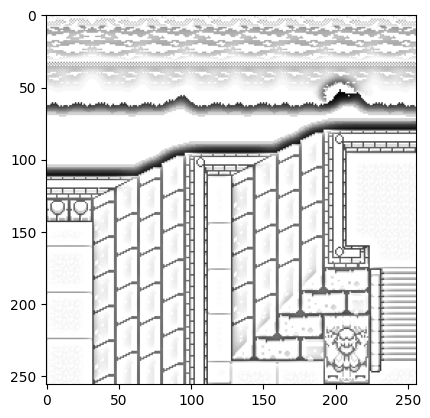

In [10]:
plt.imshow(X[0])
plt.show()

In [11]:
debug = False
#image_source_dir = './dataset/facades/'
direction = 'b2a'
input_channel = 3  # input image channels
output_channel = 3  # output image channels
lr = 0.0002
epoch = 1
crop_from = 286
#image_size = (640,480)
batch_size = 2
combined_filepath = './best_weights.h5'
generator_filepath = './generator.h5'
seed = 9584
imagenet_mean = np.array([0.5, 0.5, 0.5])
imagenet_std = np.array([0.5, 0.5, 0.5])

In [12]:
def get_crop_shape(target, refer):
        # width, the 3rd dimension
        cw = (target.get_shape()[2] - refer.get_shape()[2]).value
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1]).value
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)

In [13]:
def residual_block(feature, dropout=False):
    x = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout:
        x = Dropout(0.5)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return Add()([feature, x])

In [14]:
def conv_block(feature, out_channel, downsample=True, dropout=False):
    if downsample:
        x = Conv2D(out_channel, kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    else:
        x = Conv2DTranspose(out_channel, kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout:
        x = Dropout(0.5)(x)
    return x


In [15]:
def get_generator(n_block=3):
    input = Input(shape=(image_size[0], image_size[1], input_channel))
    x = Conv2D(64, kernel_size=7, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(input)  # use reflection padding instead
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # downsample
    x = Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # downsample
    x = Conv2D(256, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    for i in range(n_block):
        x = residual_block(x)
    # upsample
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # upsample
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # out
    x = Conv2D(output_channel, kernel_size=7, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)  # use reflection padding instead
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    generator = Model(inputs=input, outputs=x)
    return generator

In [16]:
def get_generator_unet(n_block=3):
    input = Input(shape=(image_size[0], image_size[1], input_channel))
    # encoder
    e0 = Conv2D(64, kernel_size=4, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(input)  # use reflection padding instead
    e0 = BatchNormalization()(e0)
    e0 = Activation('relu')(e0)
    e1 = conv_block(e0, 128, downsample=True, dropout=False)  # 1/2
    e2 = conv_block(e1, 256, downsample=True, dropout=False)  # 1/4
    e3 = conv_block(e2, 512, downsample=True, dropout=False)  # 1/8
    e4 = conv_block(e3, 512, downsample=True, dropout=False)  # 1/16
    e5 = conv_block(e4, 512, downsample=True, dropout=False)  # 1/32
    e6 = conv_block(e5, 512, downsample=True, dropout=False)  # 1/64
    e7 = conv_block(e6, 512, downsample=True, dropout=False)  # 1/128
    # decoder
    d0 = conv_block(e7, 512, downsample=False, dropout=True)  # 1/64
    d1 = Concatenate(axis=-1)([d0, e6])
    d1 = conv_block(d1, 512, downsample=False, dropout=True)
    d2 = Concatenate(axis=-1)([d1, e5])
    d2 = conv_block(d2, 512, downsample=False, dropout=True)  # 1/16
    d3 = Concatenate(axis=-1)([d2, e4])
    d3 = conv_block(d3, 512, downsample=False, dropout=True)  # 1/8
    d4 = Concatenate(axis=-1)([d3, e3])
    d4 = conv_block(d4, 256, downsample=False, dropout=True)  # 1/4
    d5 = Concatenate(axis=-1)([d4, e2])
    d5 = conv_block(d5, 128, downsample=False, dropout=True)  # 1/2
    d6 = Concatenate(axis=-1)([d5, e1])
    d6 = conv_block(d6, 64, downsample=False, dropout=True)  # 1
    # out
    x = Conv2D(output_channel, kernel_size=3, padding='same', kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(d6)  # use reflection padding instead
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    generator = Model(inputs=input, outputs=x)
    return generator

In [17]:
def get_generator_training_model(generator, discriminator):
    imgA = Input(shape=(image_size[0], image_size[1], input_channel))
    imgB = Input(shape=(image_size[0], image_size[1], input_channel))
    fakeB = generator(imgA)
    # discriminator.trainable=False
    realA_fakeB = Concatenate()([imgA, fakeB])
    pred_fake = discriminator(realA_fakeB)
    generator_training_model = Model(inputs=[imgA, imgB], outputs=[pred_fake, fakeB])
    return generator_training_model

In [18]:
def get_discriminator(n_layers=4, use_sigmoid=True):
    input = Input(shape=(image_size[0], image_size[1], input_channel + output_channel))
    x = Conv2D(64, kernel_size=4, padding='same', strides=2, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(input)
    x = LeakyReLU(alpha=0.2)(x)
    for i in range(1, n_layers):
        x = Conv2D(64 * 2 ** i, kernel_size=4, padding='same', strides=2, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(64 * 2 ** n_layers, kernel_size=4, padding='same', strides=1, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(1, kernel_size=4, padding='same', strides=1, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    if use_sigmoid:
        x = Activation('sigmoid')(x)
    discriminator = Model(inputs=input, outputs=x)
    return discriminator

In [19]:
train_step_per_epoch = int(len(image_id_list)*0.8) / batch_size + 1
test_step_per_epoch = int(len(image_id_list)*0.2) / batch_size + 1
train_image_generator =  DataGenerator(
    image_id_list[:int(len(image_id_list)*0.8)],
    train_path,
    batch_size=2,
    image_size=image_size,
    channels=3
)

test_image_generator = DataGenerator(
    image_id_list[int(len(image_id_list)*0.8):],
    train_path,
    batch_size=2,
    image_size=image_size,
    channels=3
)

In [20]:
opt1 = Adam(learning_rate=lr)
opt2 = Adam(learning_rate=lr)
discriminator = get_discriminator()
print(discriminator.summary())
generator = get_generator_unet()
generator.compile(optimizer=opt2, loss='mae', metrics=['mean_absolute_percentage_error', "mean_absolute_percentage_error"])
print(generator.summary())
generator_train = get_generator_training_model(generator, discriminator)
print(generator_train.summary())
if os.path.exists(combined_filepath):
    generator_train.load_weights(combined_filepath, by_name=True)
    generator.load_weights(generator_filepath, by_name=True)
    print('weights loaded!')
discriminator.compile(optimizer=opt1, loss='mse', metrics=['acc'], loss_weights=None)
generator_train.compile(optimizer=opt2, loss=['mse', 'mae'],
                        metrics=['mean_absolute_percentage_error', "acc"],
                        loss_weights=[1, 10])
real = np.ones((batch_size, 16, 16, 1))
fake = np.zeros((batch_size, 16, 16, 1))
best_loss = 1000

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 6)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      6208      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization (Batch  (None, 64, 64, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                             

2024-01-25 17:30:36.178945: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-25 17:30:36.372360: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-25 17:30:36.372411: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-25 17:30:36.380680: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-25 17:30:36.380734: I external/local_xla/xla/stream_executor

None
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 256, 256, 64)         3136      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 256, 256, 64)         256       ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_1 (Activation)   (None, 256, 256, 64)         0         ['batch_normalizati

In [21]:
for i in range(epochs):
    train_step = 0
    for imgA, imgB in train_image_generator:
        train_step += 1
        if train_step > train_step_per_epoch:
            test_step = 0
            total_loss = 0
            total_mape = 0
            for imgA, imgB in test_image_generator:
                test_step += 1
                if test_step > test_step_per_epoch:
                    break
                gloss, mape = generator.test_on_batch(imgA, imgB)
                total_loss += gloss
                total_mape += mape

            if total_loss / (test_step - 1) < best_loss:
                print('test loss improved from {} to {}'.format(best_loss, total_loss / (test_step - 1)))
                generator_train.save_weights(combined_filepath, overwrite=True)
                generator.save_weights(generator_filepath, overwrite=True)
                best_loss = total_loss / (test_step - 1)
            break
        discriminator.trainable = True
        fakeB = generator.predict(imgA.reshape(2,*image_size,3))
        loss_fake, fake_acc = discriminator.train_on_batch(np.concatenate((imgA, fakeB), axis=-1), fake)
        loss_real, real_acc = discriminator.train_on_batch(np.concatenate((imgA, imgB), axis=-1), real)
        if train_step % 20 == 0:
            print('epoch:{} train step:{}, loss d_fake:{:.2}, loss d_real:{:.2}, fake_acc:{:.2}, real_acc:{:.2}'.format(i + 1, train_step,loss_fake,loss_real,fake_acc,real_acc))

        discriminator.trainable = False
        loss = generator_train.train_on_batch([imgA, imgB], [real, imgB])
        if train_step % 20 == 0:
            print('epoch:{} train step:{} loss fool:{:.2} loss g:{:.2}'.format(i + 1, train_step, loss[1], loss[0] - loss[1]))

2024-01-25 17:30:37.895608: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


1/1 [==============================] - 2s 2s/step


2024-01-25 17:30:41.511277: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcb81bb3eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-25 17:30:41.511320: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-01-25 17:30:41.515220: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706200241.589018     479 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-01-25 17:30:46.596251: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/model_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 14ms/step
epoch:1 train step:20, loss d_fake:0.52, loss d_real:0.014, fake_acc:0.45, real_acc:0.98
epoch:1 train step:20 loss fool:0.0082 loss g:3.1
1/1 [==============================] - 0s 16ms/step
epoch:1 train step:40, loss d_fake:0.25, loss d_real:0.0049, fake_acc:0.74, real_acc:0.99
epoch:1 train step:40 loss fool:0.0016 loss g:2.5
1/1 [==============================] - 0s 15ms/step
epoch:1 train step:60, loss d_fake:0.014, loss d_real:0.0011, fake_acc:0.98, real_acc:1.0
epoch:1 train step:60 loss fool:0.00081 loss g:2.2
1/1 [==============================] - 0s 16ms/step
epoch:1 train step:80, loss d_fake:9.7e-05, loss d_real:2.6e-05, fake_acc:1.0, real_acc:1.0
epoch:1 train step:80 loss fool:0.00023 loss g:2.0
1/1 [==============================] - 0s 17ms/step
epoch:1 train step:100, loss d_fake:0.001, loss d_real:8.9e-06, fake_acc:1.0, real_acc:1.0
epoch:1 train step:100 loss fool:1.3e-05 loss g:2.5
1/1 [=============================

In [22]:
X,y = val_gen.__getitem__(7)

In [23]:
y_pred = generator.predict(X)

1/1 [==============================] - 0s 22ms/step


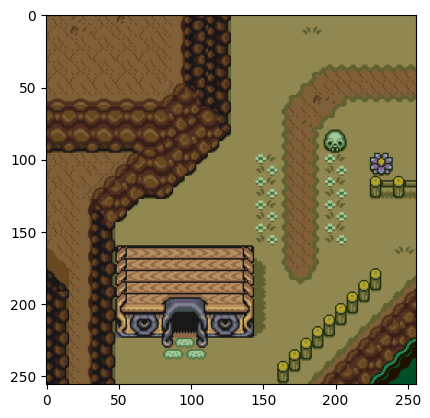

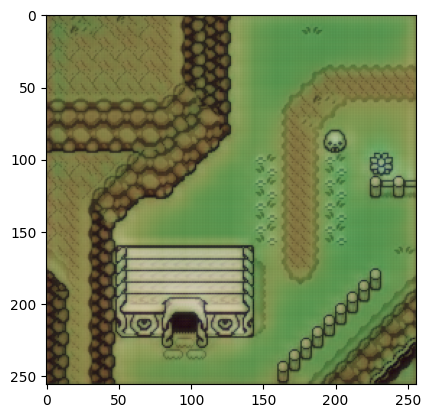

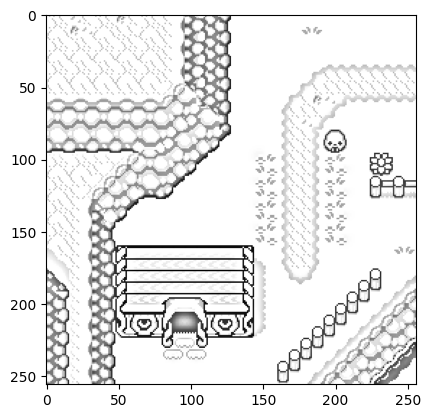

In [24]:
plt.imshow(y[0])
plt.show()
plt.imshow(y_pred[0])
plt.show()
plt.imshow(X[0])
plt.show()

generator_train.save_weights(
    combined_filepath,
    overwrite=True
)

generator.save_weights(
    generator_filepath,
    overwrite=True
)